# Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Load the dataset
flights = pd.read_csv('dataset_SCL.csv')
flights["Fecha-I"] = pd.to_datetime(flights["Fecha-I"])
flights["Fecha-O"] = pd.to_datetime(flights["Fecha-O"])

# Check the data types of the columns
print(flights.dtypes)

# Get summary statistics of the numerical variables
print(flights.describe())

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object
                             Fecha-I                        Fecha-O   
count                          68206                          68206  \
mean   2017-07-05 12:11:25.320059648  2017-07-05 12:20:31.971380992   
min              2017-01-01 00:15:00            2017-01-01 00:04:00   
25%              2017-03-31 12:41:15            2017-03-31 12:51:15   
50%              2017-07-10 05:30:00            2017-07-10 05:37:00   
75%              2017-10-08 11:18:45            2017-10-

/tmp/ipykernel_8898/3477621114.py:11: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('dataset_SCL.csv')


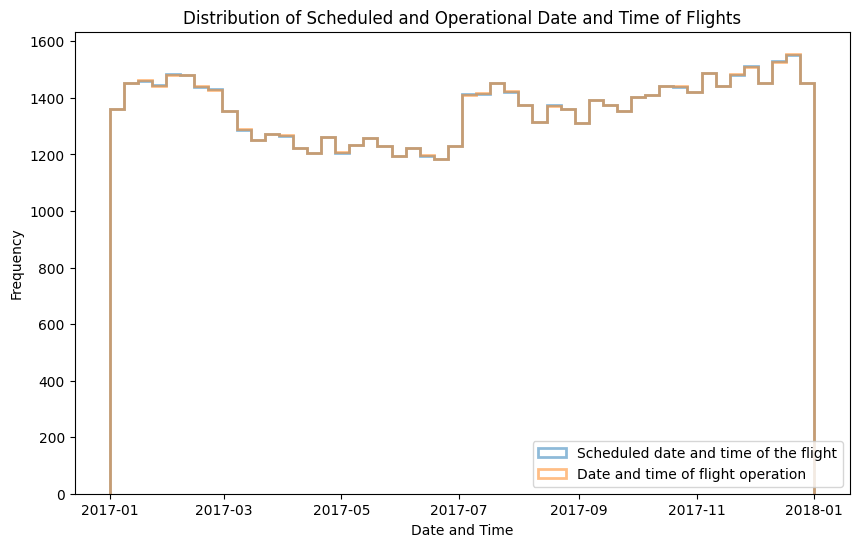

In [2]:
# Plot histograms for "Fecha-I" and "Fecha-O"
plt.figure(figsize=(10, 6))
plt.hist(flights["Fecha-I"], bins=50, alpha=0.5, label="Scheduled date and time of the flight",histtype='step', linewidth=2)
plt.hist(flights["Fecha-O"], bins=50, alpha=0.5, label="Date and time of flight operation",histtype='step', linewidth=2)
plt.legend(loc="lower right")
plt.title("Distribution of Scheduled and Operational Date and Time of Flights")
plt.xlabel("Date and Time")
plt.ylabel("Frequency")
plt.show()


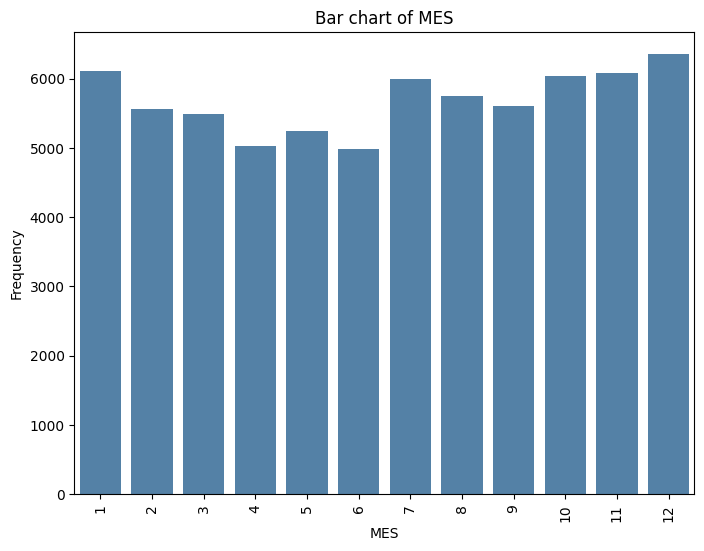

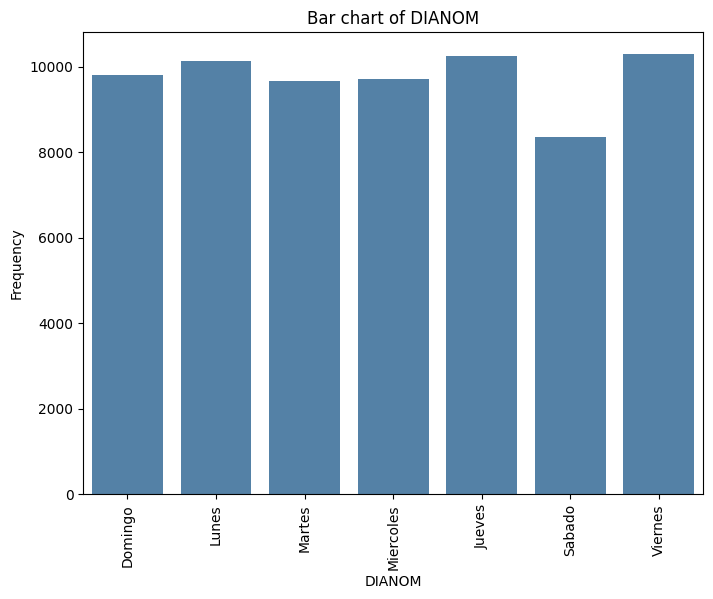

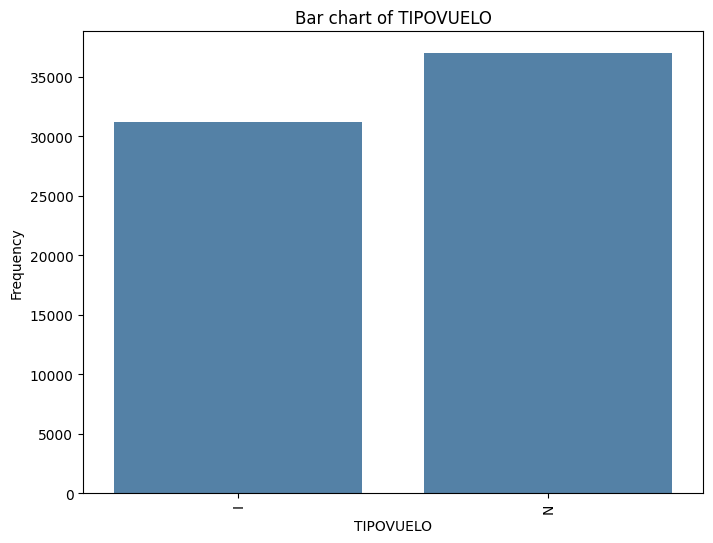

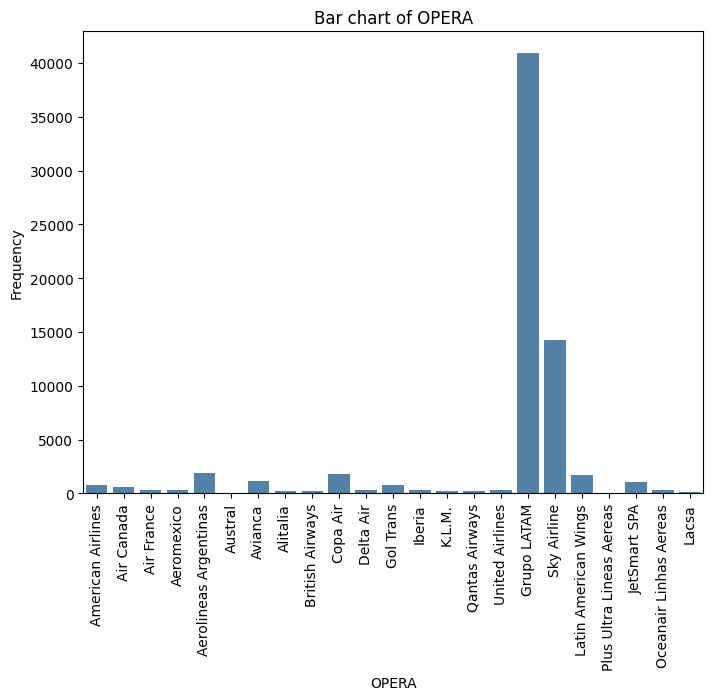

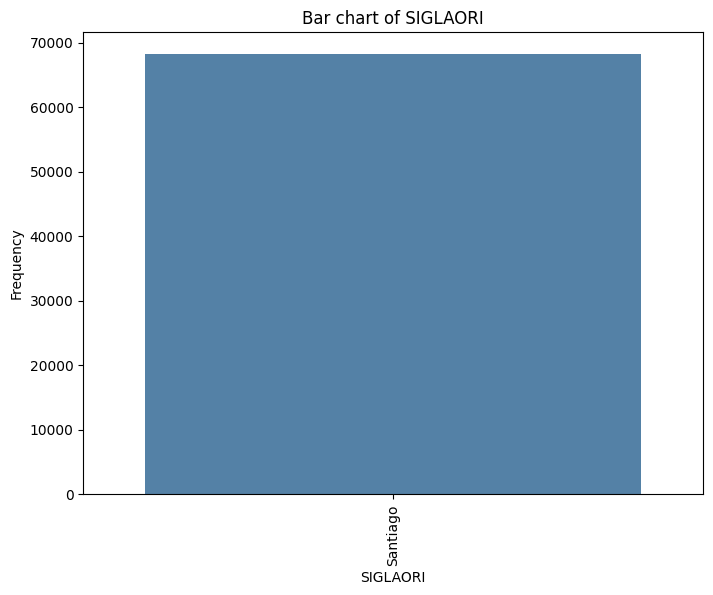

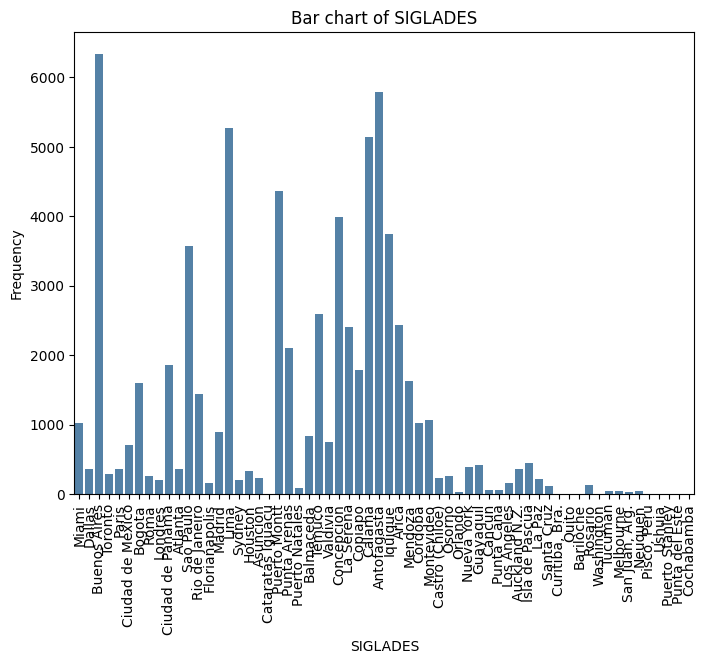

In [3]:
# Plot bar charts of the categorical variables
cat_cols = ['MES','DIANOM','TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES']
for col in cat_cols:
    plt.figure(figsize=(8,6))
    sns.countplot(x=col, data=flights, color='steelblue')
    plt.title(f'Bar chart of {col}')
    plt.xlabel(col)
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.show()

With the generated graphs, we can analyze the data for the different variables:
 - The data is distributed relatively evenly with respect to the date of operation, with a higher frequency in the months at the end and beginning of the year than in the winter months of the southern hemisphere (mid-year), with the exception of winter holidays in July.
 - All flights operate from Santiago Airport, with the airline that operates the most flights being by far the LATAM group, followed by Sky Airlines.
 - There is slightly more frequency of international flights than domestic flights.
 - Saturday is notably the day with the fewest flights.
 - The highest frequency of flights was to Buenos Aires, followed by Antofagasta, Lima, and Calama, in that order.

# Question 2

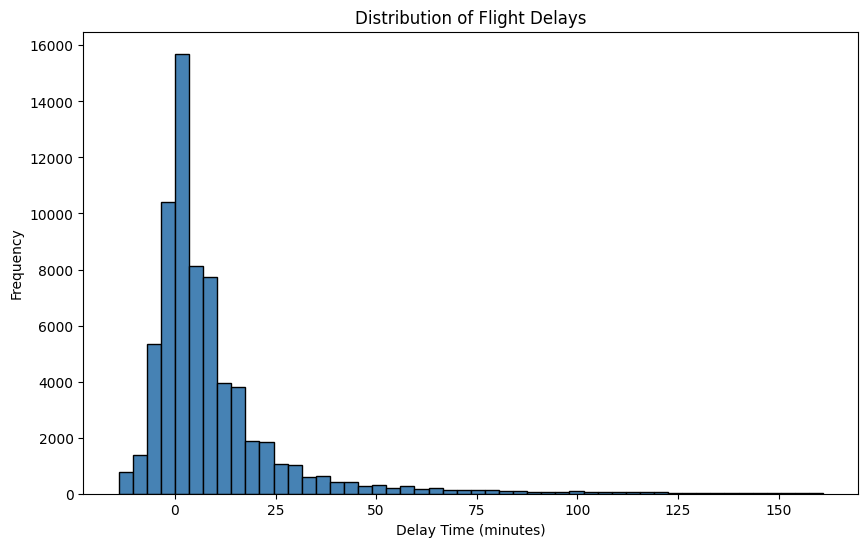

In [4]:
# Calculate the delay time in minutes as the difference between "Fecha-O" and "Fecha-I"
flights["Delay"] = (flights["Fecha-O"] - flights["Fecha-I"]).dt.total_seconds() / 60

# Plot a histogram for the delay time
plt.figure(figsize=(10, 6))
plt.hist(flights["Delay"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Flight Delays")
plt.xlabel("Delay Time (minutes)")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Create "high_season" column
flights["high_season"] = ((flights["Fecha-I"].dt.month == 12) & (flights["Fecha-I"].dt.day >= 15)) | \
                         ((flights["Fecha-I"].dt.month == 1) | (flights["Fecha-I"].dt.month == 2) | \
                          (flights["Fecha-I"].dt.month == 3) | ((flights["Fecha-I"].dt.month == 7) & \
                          (flights["Fecha-I"].dt.day >= 15)) | (flights["Fecha-I"].dt.month == 8) | \
                          (flights["Fecha-I"].dt.month == 9) & (flights["Fecha-I"].dt.day >= 11))
flights["high_season"] = flights["high_season"].astype(int)

# Create "delay_15" column
flights["delay_15"] = (flights["Delay"] > 15).astype(int)

# Create "period_day" column
flights["period_day"] = pd.cut(flights["Fecha-I"].dt.hour, bins=[0, 5, 12, 19, 24], right=False,
                               labels=["night", "morning", "afternoon", "night"],include_lowest=True, 
                               ordered=False)
    
# Export the new dataset with synthetic features to a CSV file
flights.to_csv("synthetic_features.csv", index=False)



# Question 3

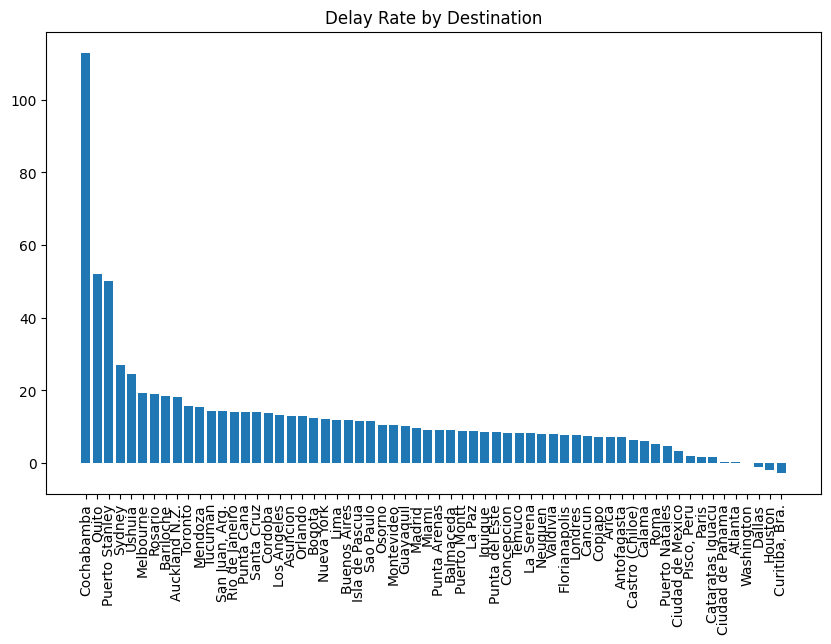

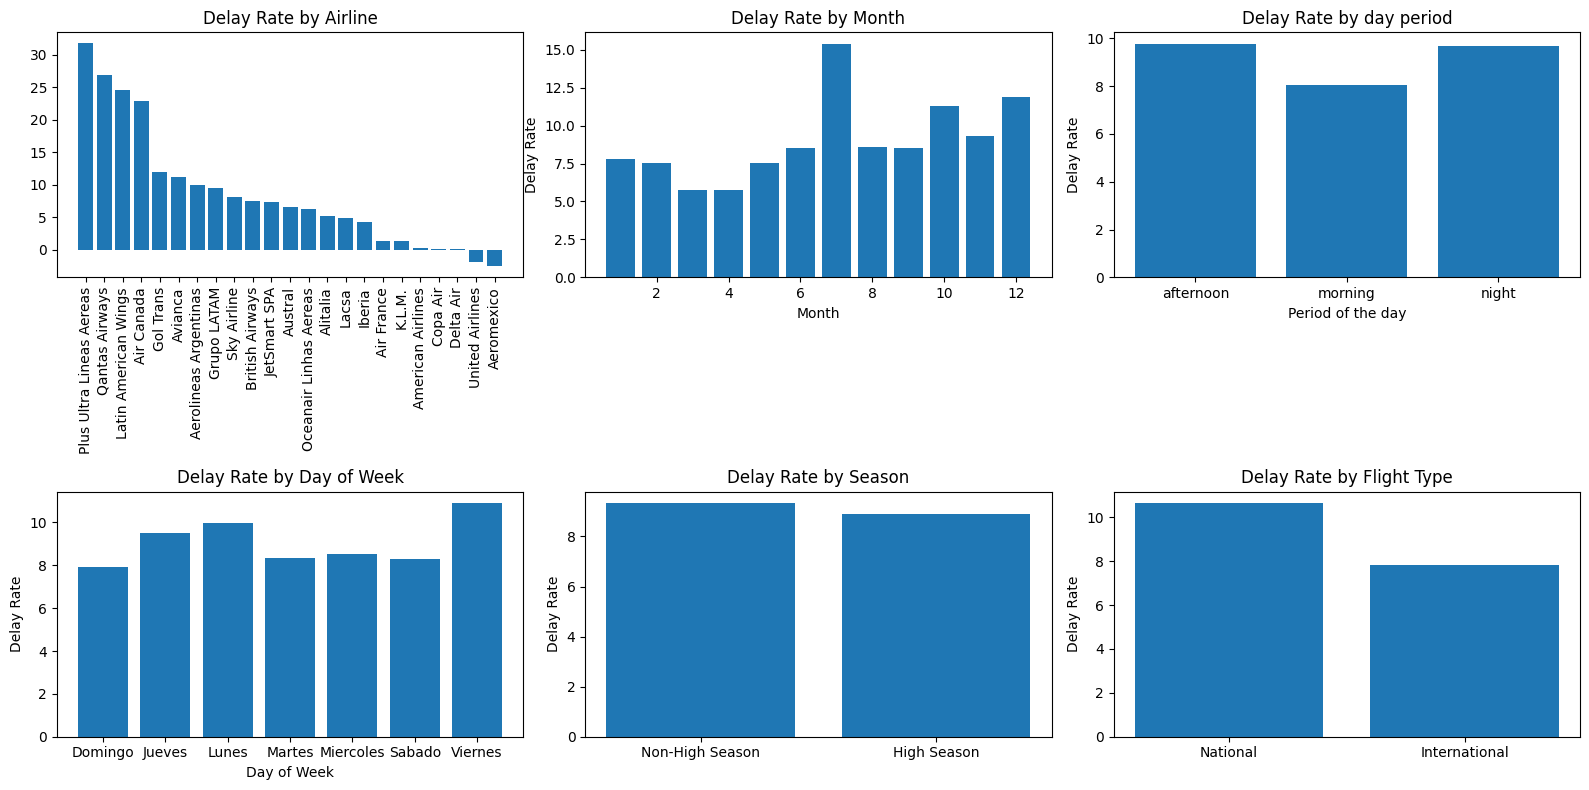

In [6]:
# Calculate delay rate across different categories
delay_by_dest = flights.groupby('SIGLADES')['Delay'].mean().sort_values(ascending=False)
delay_by_airline = flights.groupby('OPERA')['Delay'].mean().sort_values(ascending=False)
delay_by_month = flights.groupby('MES')['Delay'].mean().sort_index()
delay_by_day = flights.groupby('DIANOM')['Delay'].mean().sort_index()
delay_by_season = flights.groupby('high_season')['Delay'].mean()
delay_by_flight_type = flights.groupby('TIPOVUELO')['Delay'].mean()
delay_by_period_day = flights.groupby('period_day')['Delay'].mean()

# Plot the delay rate by destination. because its x axis is bigger
plt.figure(figsize=(10, 6))
plt.bar(delay_by_dest.index, delay_by_dest.values)
plt.title("Delay Rate by Destination")
plt.xticks(rotation=90)
plt.show()


# Plot the delay rate across different categories
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axs[0,0].bar(delay_by_airline.index, delay_by_airline.values)
axs[0,0].set_title('Delay Rate by Airline')
axs[0,0].tick_params(axis='x', rotation=90)

axs[0,1].bar(delay_by_month.index, delay_by_month.values)
axs[0,1].set_title('Delay Rate by Month')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('Delay Rate')

axs[0,2].bar(delay_by_period_day.index, delay_by_period_day.values)
axs[0,2].set_title('Delay Rate by day period')
axs[0,2].set_xlabel('Period of the day')
axs[0,2].set_ylabel('Delay Rate')

axs[1,0].bar(delay_by_day.index, delay_by_day.values)
axs[1,0].set_title('Delay Rate by Day of Week')
axs[1,0].set_xlabel('Day of Week')
axs[1,0].set_ylabel('Delay Rate')

axs[1,1].bar(delay_by_season.index, delay_by_season.values)
axs[1,1].set_title('Delay Rate by Season')
axs[1,1].set_xticks([0, 1])
axs[1,1].set_xticklabels(['Non-High Season', 'High Season'])
axs[1,1].set_ylabel('Delay Rate')

axs[1,2].bar(delay_by_flight_type.index, delay_by_flight_type.values)
axs[1,2].set_title('Delay Rate by Flight Type')
axs[1,2].set_xticks([0, 1])
axs[1,2].set_xticklabels(['National', 'International'])
axs[1,2].set_ylabel('Delay Rate')

plt.tight_layout()
plt.show()


We can obtain several insights from the data extracted. The principal conclusions are:
 - Friday, being the busiest day, also has the biggest delay rate from all the days of the week (however it os only the busiest by a few flights and has the biggest delay by an slightly important rate)
 - Saturday is not the day eith the smallest delay rate, despite being the day with less amount of flights by far.
 - National flights have more than 20% more delay rate than International flights.
 - Plus Ultra Lineas Aereas, QAntas and LAtin MAerican Wings are the airlines with the biggest delay rate, despite not beeing close to having the same amounts of flights than the more busy airlines.
 - Non high season flights have more delay than the high season ones.
 - Cochabamba is by far the destiantion with the highest delay rate.
 - Flights in the morning tend to have less delay

# Question 4

## Random Forest Regression model to predict minutes of delay for each flight

We could try to train a Random Forest Regression model to try to identify how much delay will each flight have, describing the minutes of delay as a continous variable

First we will define some functions that will help us to segment the datasets and run the models.

In [141]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score

def define_set(numerical_cols, categorical_cols, test_size, predict_column):
    # instantiate OneHotEncoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    # select the input features and the target variable
    X = flights[["DIA", "MES", "DIANOM", "TIPOVUELO", "OPERA", "SIGLADES","high_season", "period_day"]]
    y = predict_column

    # split the data into training and test sets
    # we use stratify to ensure that the proportion of positive cases is maintened in training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # fit and transform the ohe training data
    X_train_ohe = ohe.fit_transform(X_train[categorical_cols])

    # transform the test data using the fitted encoder
    X_test_ohe = ohe.transform(X_test[categorical_cols])
    if numerical_cols==[]:
        X_train_final=X_train_ohe
        X_test_final=X_test_ohe
    else:
        X_train_final = np.concatenate([X_train_ohe, X_train[numerical_cols]], axis=1)
        X_test_final = np.concatenate([X_test_ohe, X_test[numerical_cols]], axis=1)
    return [X_train_final, y_train, X_test_final, y_test]

def execute_model(rfc, X_train_final, y_train, X_test_final, y_test):
    # Fit the model using the training data
    rfc.fit(X_train_final, y_train)
    # Use the model to make predictions on the test data
    y_pred = rfc.predict(X_test_final)
    # Evaluate the model's accuracy
    conf_mat = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Print results
    print(classification_report(y_test, y_pred))
    print('Confusion matrix:\n', conf_mat)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 score:', f1)
    print('AUC:', roc_auc)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mean Squared Error: 371.551516198262


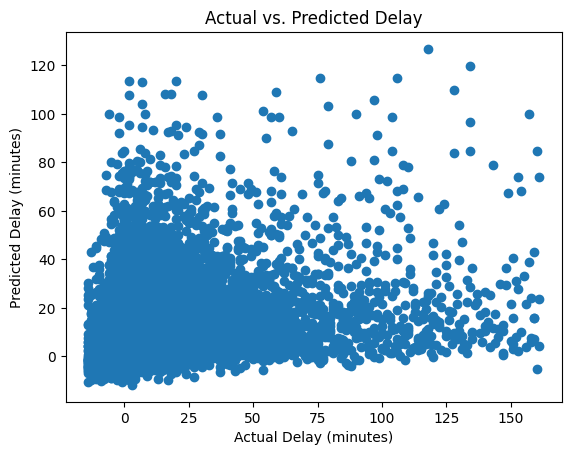

In [142]:
#Differentiate the numerical and categorical cols
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "high_season", "period_day"]
y = flights["Delay"]
test_size = 0.3
predict_column = flights["Delay"]
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)

# create a Random Forest regression object
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model using the training data
rf.fit(X_train_final, y_train)

# make predictions on the test data
y_pred = rf.predict(X_test_final)

# evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Actual vs. Predicted Delay")
plt.show()

However, we see that if we do that the mean square error is really high, considering that our predicted variable is stated in minutes, and it's clear in the plot that the model is not working. Even if we try to change the input columns of the model, leaving only the ones that visually impacted most on the delay rate in question 3 (airline and destination), the result is pretty much the same:


In [143]:
#Differentiate the numerical and categorical cols

# numerical_cols=["high_season"]
categorical_cols = ["OPERA", "SIGLADES"]
numerical_cols=[]
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)

# create a Random Forest regression object
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model using the training data
rf.fit(X_train_final, y_train)

# make predictions on the test data
y_pred = rf.predict(X_test_final)

# evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mean Squared Error: 349.20605954363424


This means that our approach of trying to predict the continous delay variable expressed in minutes is not as simple as it seems. With this, we will make the following ASSUMPTION: we will train a model to predict only if a flight is delayed or not, considering the threshold of 15 minutes (above 15 min is considered a delay) that was defined in question 2 as the variable to predict. For this we will make use of a Random forest classification model.

## Random forest classification

The usage of a random forest classification algorithm for predicting if a flight will be delayed or not is because it is less sensitive to noise, which is a good thing considering the variables that we have. Random Forest is an ensemble algorithm that combines multiple Decision Trees to improve the accuracy and robustness of the classification.

Before defining the sets, it is important to analyse that data the we have. 

In [144]:
print(f"number of non delayed flights: {flights['delay_15'].value_counts()[1]}" )
print(f"number of delayed flights: {flights['delay_15'].value_counts()[0]}")

number of non delayed flights: 12614
number of delayed flights: 55592


Here we can see that the data is imbalanced, because in our dataset there are much more non-delayed flights than delayed ones. This might be something to consider as we train our model.

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.92      0.88     16678
           1       0.38      0.23      0.29      3784

    accuracy                           0.79     20462
   macro avg       0.61      0.57      0.58     20462
weighted avg       0.75      0.79      0.77     20462

Confusion matrix:
 [[15267  1411]
 [ 2915   869]]
Accuracy: 0.7885837161567785
Precision: 0.381140350877193
Recall: 0.22965116279069767
F1 score: 0.28660949868073876
AUC: 0.5725243462352576


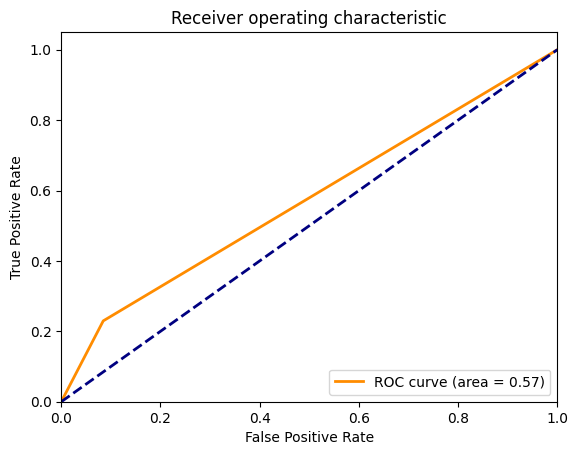

In [152]:
#We define our train and test sets.
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
predict_column=flights["delay_15"]
test_size=0.3
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)
# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
execute_model(rfc,X_train_final, y_train, X_test_final, y_test)

In order to correctly analyse the results we first must identify what is our goal. We see that our model is not very precise but have a fair enough accuracy. This data (the accuracy) by it's own does not tell us much, because accuracy is insensitive to data imbalance, and the ammount of non delayed flights are by far greater than the delayed ones. In the precision aspect, a precision of 0.38 means that out of all the flights predicted to be delayed, only 38% were actually delayed. The Recall, a measure of the proportion of actual positive cases that were correctly identified by the classifier, out of all positive cases in the dataset, is of only 23%. Finally, the AUC (measure of the classifier's ability to distinguish between positive and negative instances across all possible thresholds) is 57%. A value of 57% suggests that the model is not performing well at all in distinguishing between positive and negative cases.

If the goal of the model is to correctly identify which flights are going to be delayed, recall should be our most important parameter. In this case, it is not good that only 23% of the actual delayed flights were identified by the classificator.

The classification matrix helps to identify more precisely the defects in our model. We can conclude that the model can identify pretty well if a flights is not going to be delayed by more than 15 minutes, but considering that these are the majority of the cases (more than 80% of the cases), it is not that great. On the other side, it can predict well only 23% of the delayed flights.

It's probably a good idea to iterate on this to obtain better solutions. For this I propose 6 different approaches:
1. To iterate through the parameters of the model, n_estimators and the seed that starts the model (random_state).
2. To change the columns that we input the model to only ones that we think might have a greater weight on the chances of being delay (the destination and the airline, for example).
3. Increase training set length
4. Oversample data
5. Undersample data
6. Try with other models and compare them.

### To iterate through the parameters of the model

We will iterate with different numbers of estimators and random_states and use GridSearchCV to catch the best tunning. This might take some minutes, as having more estimators normally takes longer.

In [25]:
from sklearn.model_selection import GridSearchCV

# assume X_train, y_train are already defined

# define a range of values for n_estimators and random_state
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'random_state': [42, 123, 456, 789]
}

# create a Random Forest classifier
rfc = RandomForestClassifier(max_depth=10)

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train_final, y_train)

# print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'n_estimators': 100, 'random_state': 42}
Best score: 0.82


After 3 minutes of solving, the solution tell us to stay with the first parameters that we stated. 

### To change the input columns

Now we will change the input columns to the model, considering only those columns that visually appeared to import the most on a flight being delayed. Let's consider the destination, the operating airline and the month as our input columns. We reset our training and testing datasets:

### With month, airline and destination

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16678
           1       0.57      0.07      0.12      3784

    accuracy                           0.82     20462
   macro avg       0.70      0.53      0.51     20462
weighted avg       0.78      0.82      0.75     20462

Confusion matrix:
 [[16487   191]
 [ 3532   252]]
Accuracy: 0.818052976248656
Precision: 0.5688487584650113
Recall: 0.06659619450317125
F1 score: 0.11923349893541518
AUC: 0.527571991003834


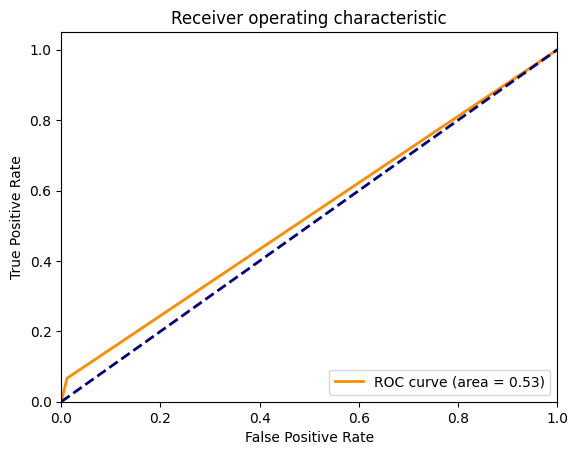

In [153]:
#We reset our train and test sets

numerical_cols=["MES"]
categorical_cols = ["OPERA", "SIGLADES"]
test_size=0.3

X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)
execute_model(rfc, X_train_final, y_train, X_test_final, y_test)


Interestingly, both accuracy and precision improved notoriously, specially the case of precission, where now we can say that out of all the flights predicted to be delayed, 60% were actually delayed. However, our AUC (measure of the classifier's ability to distinguish between positive and negative instances across all possible thresholds) is 53%, which is even worse than before. A value of 53% suggests that the model is not performing well at all in distinguishing between positive and negative cases. 

However, and more negatively, the model Recall has dropped to 0.065. Only 6.5% of delayed flights were correctly identified as delayed by the classifier. In other words, the classifier missed the vast majority of the actual delayed flights. If our goal is recall, as we mentioned before, we have a lot of worse performance than before, so changing the columns input did not help.

As before, we can conclude that the model can identify pretty well if a flight is not going to be delayed by more than 15 minutes, but considering that these are the majority of the cases (more than 80% of the cases), it is again not that great. This is represented in the AUC=53%.

In order to understand why we have a decent accuracy but such horrible recall, we can say that when a classifier has an accuracy of 81.8% but a recall of 6.5%, it means that the classifier is making correct predictions for the majority of cases (81% of all flights, delayed or not), but is missing a large number of actually delayed flights.

### Increase training set length

Now, let's go back to the original columns that we input the model in the first Random Forest model and try to have a largest training set to see if that helps us to train our model better. Let's reset our sets:

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.91      0.88      5560
           1       0.38      0.23      0.29      1261

    accuracy                           0.79      6821
   macro avg       0.61      0.57      0.58      6821
weighted avg       0.75      0.79      0.77      6821

Confusion matrix:
 [[5083  477]
 [ 971  290]]
Accuracy: 0.787714411376631
Precision: 0.37809647979139505
Recall: 0.22997620935765264
F1 score: 0.2859960552268245
AUC: 0.5720924212255889


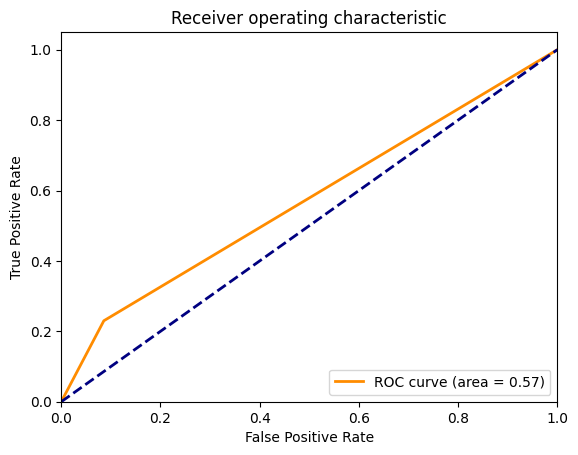

In [108]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.1
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)
execute_model(rfc, X_train_final, y_train, X_test_final, y_test)

We mostly see that both Recall and precision maintins steady, even though we augmented the train set by 20% of the whole dataset. So this is also a bad solution.

### Oversampling data

As we mentioned before, the data in the model is highly imbalanced. This could be the reason of our bad REcall results, let's try to oversample the amount of delayed flights. In the oversampling technique, we are generating new samples from the minority class (positive, delayed flights) to balance the dataset. In the undersampling technique, we are randomly selecting a subset of the majority class (negative) to balance the dataset.

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.83      0.84     16678
           1       0.32      0.35      0.33      3784

    accuracy                           0.74     20462
   macro avg       0.58      0.59      0.59     20462
weighted avg       0.75      0.74      0.75     20462

Confusion matrix:
 [[13809  2869]
 [ 2448  1336]]
Accuracy: 0.7401524777636594
Precision: 0.3177170035671819
Recall: 0.35306553911205074
F1 score: 0.334459882338215
AUC: 0.5905212573843022


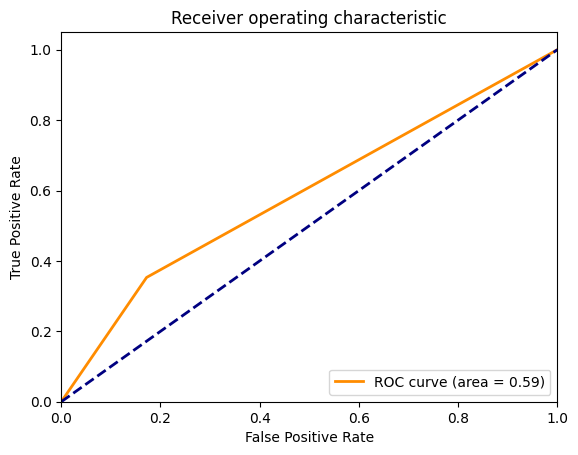

In [148]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)

from imblearn.over_sampling import RandomOverSampler
# Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_final, y_train)
execute_model(rfc, X_train_over, y_train_over, X_test_final, y_test)


Comparing this result with the other ones, we can appreciate that oversampling data has improved Recall and AUC. Not to the levels that we would want to see, but it is in fact an improvement. This means that having the data imbalanced in such a way that mostly 80% of the data is negative (non delayed flights) caused some trobules with this model.

### Undersampling data

 If we consider now undersampling the non delayed flights, we obtain the following:

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.83      0.84     16678
           1       0.32      0.35      0.33      3784

    accuracy                           0.74     20462
   macro avg       0.58      0.59      0.59     20462
weighted avg       0.75      0.74      0.75     20462

Confusion matrix:
 [[13835  2843]
 [ 2456  1328]]
Accuracy: 0.7410321571693872
Precision: 0.3183888755694078
Recall: 0.35095137420718814
F1 score: 0.33387806411062226
AUC: 0.5902436448922977


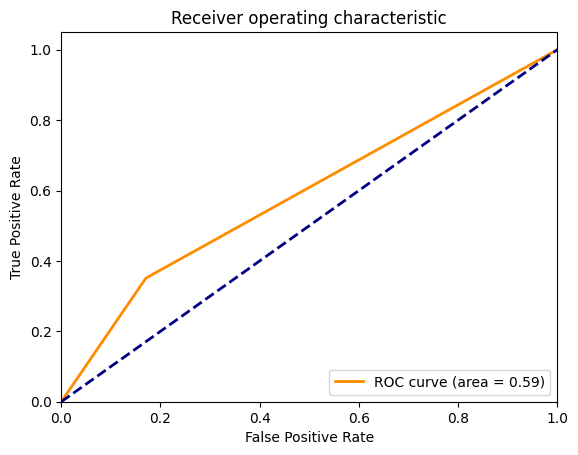

In [111]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size, predict_column=predict_column)

from imblearn.under_sampling import RandomUnderSampler
# Undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
execute_model(rfc, X_train_over, y_train_over, X_test_final, y_test)

We see that we mostly obtain the same results with oversampling than with undersampling.

### Training other models

In order to see if maybe other models obtain a better performance in identifying correctly the delayed flights, lets make a comparisson between the random forest classificator, a logistic regression and a decision Tree classifier. According to the theory, Logistic Regression is a linear classification algorithm that works well when the decision boundary is assumed to be linear, Decision Trees are non-linear algorithms that work well when the decision boundary is complex and non-linear, and Random Forest is an ensemble algorithm that combines multiple Decision Trees to improve the accuracy and robustness of the classification.

In this case, we will not compare the resulted predicted results, but with the predicted probabilities of the model using 'probs'. With this, thre threshold of deciding if a flight is delayed when the probability of the predicted class is over 0.5 is not applied and just the probabilities are considered. This results in a much more smooth AUC plots.

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/jpmena/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6767586524683313 0.5006161429451633
0.5733436755341996 0.5634161831208623
0.6802403065414991 0.5400895194637754
Logistic Regression Recall:  0.0012322858903265558
Decision Tree Recall:  0.17991373998767715
Random Forest Recall:  0.1059765865680838


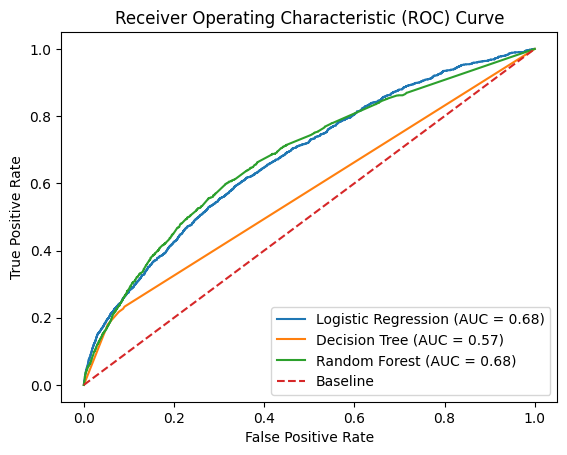

In [137]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size,  predict_column=predict_column)

# Initialize models
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Train models
lr.fit(X_train_final, y_train)
dt.fit(X_train_final, y_train)
rf.fit(X_train_final, y_train)

# Predict probabilities on testing set
lr_probs = lr.predict_proba(X_test_final)[:, 1]
dt_probs = dt.predict_proba(X_test_final)[:, 1]
rf_probs = rf.predict_proba(X_test_final)[:, 1]

lr_y_pred = lr.predict(X_test_final)
dt_y_pred = dt.predict(X_test_final)
rf_y_pred = rf.predict(X_test_final)

# Calculate AUC scores
lr_auc = roc_auc_score(y_test, lr_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

lr_auc_y = roc_auc_score(y_test, lr_y_pred)
dt_auc_y = roc_auc_score(y_test, dt_y_pred)
rf_auc_y = roc_auc_score(y_test, rf_y_pred)

print(lr_auc, lr_auc_y)
print(dt_auc, dt_auc_y)
print(rf_auc, rf_auc_y)



# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot ROC curves
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (AUC = {:.2f})'.format(dt_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_auc))

# Plot baseline
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Show plot
plt.show()

In [ ]:
lr_rec_y = recall_score(y_test, lr_y_pred)
dt_rec_y = recall_score(y_test, dt_y_pred)
rf_rec_y = recall_score(y_test, rf_y_pred)

print("Logistic Regression Recall: ",lr_rec_y)
print("Decision Tree Recall: ",dt_rec_y)
print("Random Forest Recall: ",rf_rec_y)

We see that decision tree model obtains a better Recall than the Random Forest one. As Random forest is defined as a composition of decision trees, maybe random forest is porpagating the bias and errors that exists in the decision tree model and that's why it worsens it's performance-

Let's then make an attempt to use the Decision tree oversampling the data.

/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.80      0.83     16678
           1       0.30      0.38      0.34      3784

    accuracy                           0.72     20462
   macro avg       0.58      0.59      0.58     20462
weighted avg       0.75      0.72      0.74     20462

Confusion matrix:
 [[13379  3299]
 [ 2342  1442]]
Accuracy: 0.724318248460561
Precision: 0.30415524151022993
Recall: 0.3810782241014799
F1 score: 0.3382991202346041
AUC: 0.5916363659181101


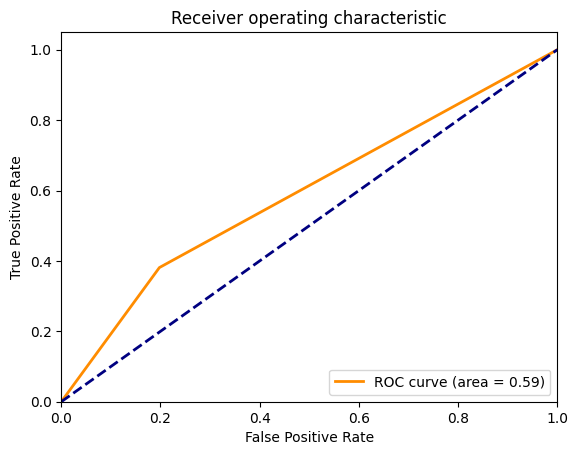

In [127]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size,  predict_column=predict_column)

dt = DecisionTreeClassifier(random_state=42)
from imblearn.over_sampling import RandomOverSampler
# Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_final, y_train)
execute_model(dt, X_train_over, y_train_over, X_test_final, y_test)


Let's compare this model with the original Random forest classificator:

Original Random Forest:
Accuracy: 0.7885837161567785
Precision: 0.381140350877193
Recall: 0.22965116279069767
F1 score: 0.28660949868073876
AUC: 0.5725243462352576

Oversampled Decision tree:
Accuracy: 0.724318248460561
Precision: 0.30415524151022993
Recall: 0.3810782241014799
F1 score: 0.3382991202346041
AUC: 0.5916363659181101

We can appreciate that we managed to improve the Recall (the % of the delayed flights in the test set that were actually classified as delayed) but the trade-off was to loose some accuracy and precission.

### Alternative apporach: changing the threshold

Now that we have tried changing the input and the parameters, the model misses on the important thing, that is trying to identify which flights will actually be delayed. It can respond better to identify which flights will not be delayed, but it struggles to identify the positive cases.

To try to improve the model, we will change the threshold of considering a flight delayed. This is, ASSUMPTION: WE WILL WE ARE GOING TO CONSIDER A FLIGHT DELAYED WHEN THE ACTUAL DELAY IS DIFFERENT THAN 15 MINUTES.

We will try incresing the threshold to 10 and then 30 minutes. We will make this using our last parameters of only considering month, airline and destination. Before doing this, let's think for a minute what we are doing. If the model was struggling to correctly identifying actual delayed flights, if we lower the threshold, thus making more flights delayed, the precision and recall of the positive (delayed) flights should improve if we mantain our input columns. On the other hand, if we make the threshold higher, even less flights will be labeled as delay, and the model should have even worst performance.

In [133]:
#First we create two new columns to the dataset:

# Create "delay_10" column
flights["delay_10"] = (flights["Delay"] > 10).astype(int)
# Create "delay_30" column
flights["delay_30"] = (flights["Delay"] > 30).astype(int)


/home/jpmena/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      0.90      0.92     18839
           1       0.18      0.25      0.21      1623

    accuracy                           0.85     20462
   macro avg       0.56      0.58      0.57     20462
weighted avg       0.87      0.85      0.86     20462

Confusion matrix:
 [[17044  1795]
 [ 1219   404]]
Accuracy: 0.8527025706187078
Precision: 0.18371987266939518
Recall: 0.24892174984596427
F1 score: 0.21140763997906856
AUC: 0.5768203419859897


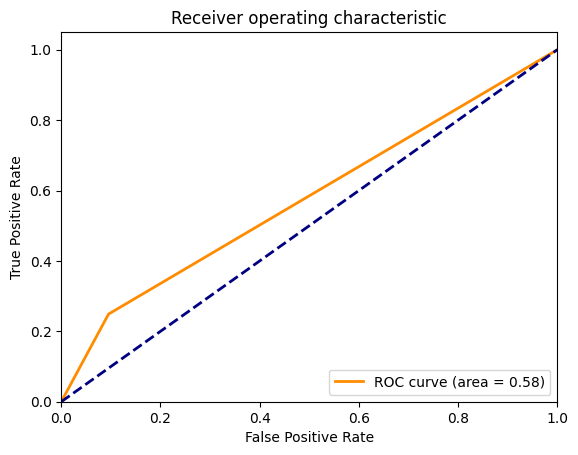

In [135]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
predict_column=flights["delay_10"]
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size,  predict_column=predict_column)

dt = DecisionTreeClassifier(random_state=42)
from imblearn.over_sampling import RandomOverSampler
# Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_final, y_train)
execute_model(dt, X_train_over, y_train_over, X_test_final, y_test)

In [ ]:
numerical_cols=["DIA","MES","high_season"]
categorical_cols = ["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "period_day"]
test_size=0.3
predict_column=flights["delay_30"]
X_train_final, y_train, X_test_final, y_test=define_set(numerical_cols=numerical_cols, categorical_cols=categorical_cols, test_size=test_size,  predict_column=predict_column)

dt = DecisionTreeClassifier(random_state=42)
from imblearn.over_sampling import RandomOverSampler
# Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_final, y_train)
execute_model(dt, X_train_over, y_train_over, X_test_final, y_test)

## Final conclusions

In order to reach a satisfactory conclusion, we can say that, with the data given, none of the models trained are able to predict if a flight will be delayed in a precise way, which is reflected on the Recall and precission scores of the models analysed. It is important to mention that, for a correct use of the predicitions models, the classificator algorithm, the dataset used and the parameters to use will depend mostly on the specific business goal and the associated cost of false positives and false negatives of the model.

If the cost of missing a delayed flight (false negative) is high, then recall would be more important, as it represents the ability of the model to correctly identify delayed flights. However, this may come at the expense of precision, as the model may identify more false positives (non-delayed flights predicted as delayed).

If the cost of predicting a delayed flight when it is not delayed (false positive) is high, then precision would be more important, as it represents the ability of the model to correctly identify non-delayed flights. This may come at the expense of recall, as the model may miss more delayed flights.

If the cost of both false positives and false negatives are high and need to be balanced, then the AUC metric may be more suitable, as it takes into account the overall performance of the model in terms of both true positives and true negatives.

After that, we can assume that some kind of different data of the flights would have allowed us to build a more precise model. Normally, flights are affected by weather conditions, that might not necesarilly be specific to a destination or a given month of the year, and it's occurance can be distributed in different ways accross both destination and datetime. In order to try to internalize these aspects (weather related to destinations and/or dates of the year), the data used should have more than one year of information, in order to identify weather patrons. It would be interesting to see if having more than one year of data would improve the model reliability.